# Overview

Tasty Bytes is one of the largest food truck networks in the world with localized menu options spread across 30 major cities in 15 countries. **Tasty Bytes is aiming to achieve 25% YoY sales growth over 5 years.**

As Tasty Bytes Data Scientists, we have been asked to support this goal by helping our food truck drivers more intelligently pick where to park for shifts. **We want to direct our trucks to locations that are expected to have the highest sales on a given shift. This will maximize our daily revenue across our fleet of trucks.**

To provide this insight, we will use historical shift sales at each location to build a model. This data has been made available to us in Snowflake.

Our model will provide the predicted sales at each location for the upcoming shift.


**This is an introduction to Snowpark for Snowflake.
We will use Snowpark to:**

- Explore the data
- Perform feature engineering
- Train a model
- Deploy the model in Snowflake


**Why Snowpark?**

- No copies or movement of data
- Maintain governance
- Leverage Snowflake scalable compute
- ...and more!


# Before you begin

You will be running this as a Snowflake Notebook, so you will need to add the following packages in the Packages drop-down menu in the upper right corner of the UI:
- matplotlib 
- plotly
- snowflake-ml-python

--------------
# ❄️ SNOWPARK 101 ❄️
--------------


Let's get to know Snowpark. We will see that Snowpark makes it easy for Python users to leverage the Snowflake platform. Bringing these users into the Snowflake platform will foster collaboration and  streamline architecture across all users and teams.

## Import Packages
Just like the Python packages we are importing, we will import the Snowpark modules that we need.<br>
**Value**: Snowflake modules provide efficient ways to work with data and functions in Snowflake. 

In [4]:
# Import Python packages
import pandas as pd
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import json
import sys
import cachetools
from datetime import timedelta
import math

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.ml.modeling.impute import SimpleImputer
from snowflake.ml.modeling.preprocessing import OneHotEncoder
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.linear_model import LinearRegression
from snowflake.ml.registry import Registry
from snowflake.ml.modeling.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# For display purposes, suppress FutureWarnings and UserWarnings from printing below the cells
import warnings
for warning_category in [FutureWarning, UserWarning]:
    warnings.filterwarnings('ignore', category=warning_category)

## Connect to Snowflake
Our Snowflake role, **tasty_bytes_ds_role**, can access the data in the **analytics** schema of the **frostbyte_tasty_bytes_dev** database. We will use the **tasty_dsci_wh** warehouse that has been created as a dedicated compute for data science workloads.

**Value:** Secure and governed. 

In [6]:
# Get active session 
from snowflake.snowpark.context import get_active_session
session = get_active_session()

# Add a query tag to the session. This helps with debugging and performance monitoring.
session.query_tag = {"origin":"sf_sit", "name":"snowpark_101_ds", "version":{"major":2, "minor":0},"attributes":{"is_quickstart":1, "source":"notebook"}}

# Print the current role, warehouse, and database/schema
print(f"role: {session.get_current_role()} | WH: {session.get_current_warehouse()} | DB.SCHEMA: {session.get_fully_qualified_current_schema()}")

The context of the connection created above will have the role, warehouse, database, and schema that were specified when creating this Snowflake Notebook. 

If we want to change any aspects of that context, we can use Session methods as seen in the following cell.

In [7]:
# Set session context
session.use_role('tasty_bytes_ds_role') 
session.use_database('frostbyte_tasty_bytes_dev')
session.use_schema("analytics")
session.use_warehouse("TASTY_DSCI_WH")

print(f"role: {session.get_current_role()} | WH: {session.get_current_warehouse()} | DB.SCHEMA: {session.get_fully_qualified_current_schema()}")

role: "TASTY_BYTES_DS_ROLE" | WH: "TASTY_DSCI_WH" | DB.SCHEMA: "FROSTBYTE_TASTY_BYTES_DEV"."ANALYTICS"


## Snowpark DataFrame
Let's create a Snowpark DataFrame containing our shift sales data from the **shift_sales_v** view in our Snowflake account using the Snowpark session.table function. A DataFrame is a data structure that contains rows and columns, similar to a SQL table.<br>
**Value:** Familiar representation of data for Python users.

In [8]:
snowpark_df = session.table("frostbyte_tasty_bytes_dev.analytics.shift_sales_v")

## Preview the Data
With our Snowpark DataFrame defined, let’s use the .show() function to take a look at the first 10 rows. <br>
**Value:** Instant access to data.

In [9]:
snowpark_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"CITY"         |"DATE"      |"SHIFT_SALES"  |"SHIFT"  |"MONTH"  |"DAY_OF_WEEK"  |"CITY_POPULATION"  |"LATITUDE"  |"LONGITUDE"  |"LOCATION_NAME"               |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2574           |New York City  |2023-05-02  |NULL           |AM       |5        |2              |8804190            |40.731148   |-74.003081   |Faicco's Italian Specialties  |
|2574           |New York City  |2023-05-05  |NULL           |AM       |5        |5              |8804190            |40.731148   |-74.003081   |Faicco's Italian Specialties  |
|2574           |New York City  |2023-05-01  |NULL           |AM       |5        |1              |8804190          

## Select, Filter, Sort
Notice the Null values for "shift_sales". Let's look at a single location.

To do this, we will make another Snowpark DataFrame, location_df, from the above DataFrame and we will:
1. Select columns
2. Filter to a single location ID
3. Sort by date

**Value**: Efficient transformation pipelines using Python syntax and chained logic.

In [10]:
# Select
location_df = snowpark_df.select("date", "shift", "shift_sales", "location_id", "city")

# Filter
location_df = location_df.filter(F.col("location_id") == 1135)

# Sort
location_df = location_df.order_by(["date", "shift"], ascending=[0, 0])

# Display
location_df.show(n=20)

--------------------------------------------------------------------
|"DATE"      |"SHIFT"  |"SHIFT_SALES"  |"LOCATION_ID"  |"CITY"     |
--------------------------------------------------------------------
|2023-05-07  |PM       |NULL           |1135           |Vancouver  |
|2023-05-07  |AM       |NULL           |1135           |Vancouver  |
|2023-05-06  |PM       |NULL           |1135           |Vancouver  |
|2023-05-06  |AM       |NULL           |1135           |Vancouver  |
|2023-05-05  |PM       |NULL           |1135           |Vancouver  |
|2023-05-05  |AM       |NULL           |1135           |Vancouver  |
|2023-05-04  |PM       |NULL           |1135           |Vancouver  |
|2023-05-04  |AM       |NULL           |1135           |Vancouver  |
|2023-05-03  |PM       |NULL           |1135           |Vancouver  |
|2023-05-03  |AM       |NULL           |1135           |Vancouver  |
|2023-05-02  |PM       |NULL           |1135           |Vancouver  |
|2023-05-02  |AM       |NULL      

We can see that shift sales are populated 8 days prior to the latest date in the data. The **missing values** represent future dates that do not have shift sales yet.


## Snowpark works in two main ways:
1. Snowpark code translated and executed as SQL on Snowflake
2. Python functions deployed in a secure sandbox in Snowflake 

## Explain the Query
Let's look at what was executed in Snowflake to create our location_df DataFrame.

The translated SQL query can be seen in the Snowsight interface under *Activity* in the *Query History* or directly in our notebook by using the explain() function.

**Value:** Transparent execution and compute usage.

In [11]:
location_df.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT "DATE", "SHIFT", "SHIFT_SALES", "LOCATION_ID", "CITY" FROM frostbyte_tasty_bytes_dev.analytics.shift_sales_v WHERE ("LOCATION_ID" = 1135 :: INT) ORDER BY "DATE" DESC NULLS LAST, "SHIFT" DESC NULLS LAST
Logical Execution Plan:
GlobalStats:
    partitionsTotal=2
    partitionsAssigned=2
    bytesAssigned=27725312
Operations:
1:0     ->Result  SHIFT_SALES.DATE, SHIFT_SALES.SHIFT, SHIFT_SALES.SHIFT_SALES, SHIFT_SALES.LOCATION_ID, SHIFT_SALES.CITY  
1:1          ->Sort  SHIFT_SALES.DATE DESC NULLS LAST, SHIFT_SALES.SHIFT DESC NULLS LAST  
1:2               ->Filter  SHIFT_SALES.LOCATION_ID = 1135  
1:3                    ->TableScan  FROSTBYTE_TASTY_BYTES_DEV.HARMONIZED.SHIFT_SALES  LOCATION_ID, CITY, DATE, SHIFT_SALES, SHIFT  {partitionsTotal=2, partitionsAssigned=2, bytesAssigned=27725312}

--------------------------------------------


## Compare DataFrame Size
Let's bring a sample of our Snowflake dataset to our Python environment in a pandas DataFrame using the to_pandas() function. We will compare how much memory is used for the pandas DataFrame compared to the Snowpark DataFrame. As we will see, no memory is used for the Snowpark DataFrame in our Python environment. All data in the Snowpark DataFrame remains on Snowflake.<br>

**Value:** No copies or movement of data when working with Snowpark DataFrames.

In [12]:
# Bring 10,000 rows from Snowflake to pandas
pandas_df = snowpark_df.limit(10000).to_pandas()

# Get Snowpark DataFrame size
snowpark_size = sys.getsizeof(snowpark_df) / (1024*1024)
print(f"Snowpark DataFrame Size (snowpark_df): {snowpark_size:.2f} MB")

# Get pandas DataFrame size
pandas_size = sys.getsizeof(pandas_df) / (1024*1024)
print(f"Pandas DataFrame Size (pandas_df): {pandas_size:.2f} MB")

Snowpark DataFrame Size (snowpark_df): 0.00 MB
Pandas DataFrame Size (pandas_df): 2.57 MB


--------------
# ❄️ DATA EXPLORATION ❄️ 
--------------

Here, we will use Snowpark to explore our data. A common pattern for exploration is to use Snowpark to manipulate our data and then bring an aggregate table to our Python environment for visualization. <br>

**Value:** 
   - Native Snowflake performance and scale for aggregating large datasets. 
   - Easy transfer of aggregate data to the client-side environment for visualization.
   
<br>As we explore our data, we will highlight what is being done in Snowflake and what we are transferring to our client-side environment (Python notebook environment) for visualization.

## How many rows are in our data?
This will give us an idea of how we might need to approach working with this data. Do we have enough data to build a meaningful model? What compute might be required? Will we need to sample the data?<br>
**What's happening where?:** Rows counted in Snowflake. No data transfer.

In [13]:
snowpark_df.count()

1938202

## Let's calculate some descriptive statistics.
We use the Snowpark describe() function to calculate summary statistics and then bring the aggregate results into a pandas DataFrame to visualize in a formatted table.<br>
**What's happening where?:** Summary statistics calculated in Snowflake. Transfer aggregate summary statistics for client-side visualization.

In [14]:
snowpark_df.describe().to_pandas()

,SUMMARY,LOCATION_ID,CITY,SHIFT_SALES,SHIFT,MONTH,DAY_OF_WEEK,CITY_POPULATION,LATITUDE,LONGITUDE,LOCATION_NAME
0,count,1.938202e+06,1938202,1.755096e+06,1938202,1.938202e+06,1.938202e+06,1.938202e+06,1.938202e+06,1.938202e+06,1938202
1,stddev,4.234979e+03,None,4.381358e+02,None,3.223800e+00,1.996656e+00,4.566943e+06,2.839821e+01,7.830981e+01,None
2,max,1.551700e+04,Warsaw,4.785360e+03,PM,1.200000e+01,6.000000e+00,1.634983e+07,5.948668e+01,1.513234e+02,コタン コミチ
3,mean,8.119924e+03,None,6.092432e+02,None,6.169526e+00,3.000784e+00,4.325339e+06,3.168076e+01,-3.415415e+00,None
4,min,1.001000e+03,Barcelona,7.600000e-01,AM,1.000000e+00,0.000000e+00,1.056610e+05,-3.832745e+01,-1.232431e+02,5th Avenue


## What are the numeric columns?
We want to understand the data types in our data and how we might need to handle them in preparation for modeling. For numeric columns, this could include normalizing the data to the same scale or applying a transformation to change the distribution.

**What's happening where?:** The Snowflake table schema is used to get metadata information about the data. No data transfer.

In [15]:
# Define Snowflake numeric types
numeric_types = [T.DecimalType, T.DoubleType, T.FloatType, T.IntegerType, T.LongType]

# Get numeric columns
numeric_columns = [col.name for col in snowpark_df.schema.fields if type(col.datatype) in numeric_types]
numeric_columns

['LOCATION_ID',
 'SHIFT_SALES',
 'MONTH',
 'DAY_OF_WEEK',
 'CITY_POPULATION',
 'LATITUDE',
 'LONGITUDE']

## What are the categorical columns?
Our model requires all features to be numeric. We want to identify columns that we will need to transform to a numeric representation if we would like to use them as features in our model.<br>
**What's happening where?:** The Snowflake table schema is used to get metadata information about the data. No data transfer.

In [16]:
# Define Snowflake categorical types
categorical_types = [T.StringType]

# Get categorical columns
categorical_columns = [col.name for col in snowpark_df.schema.fields if type(col.datatype) in categorical_types]
categorical_columns

['CITY', 'SHIFT', 'LOCATION_NAME']

## What are the average shift sales (USD) by city?
Here, we are trying to understand what a "normal" shift sale looks like. What is the span of averages across cities? Are there any outlier cities that should be removed from our training data? Is there anything unexpected in the order of cities sorted by their average shift sales?<br>
**What's happening where?:** Average sales by city calculated in Snowflake. Transfer city averages for client-side visualization.

In [ ]:
# Group by city and average shift sales
analysis_df = snowpark_df.group_by("city").agg(F.mean("shift_sales").alias("avg_shift_sales"))

# Sort by average shift sales
analysis_df = analysis_df.sort("avg_shift_sales", ascending=True)

# Pull to pandas and plot
analysis_df.to_pandas().plot.barh(x="CITY", y="AVG_SHIFT_SALES")

## Looking at Vancouver, how many locations are there?
We are going to use Vancouver, Canada as our test city when predicting the best location for future shifts. Let's get to know locations and shift sales in that city. First, we will see how many location options there are in Vancouver for a food truck to park.<br>
**What's happening where?:** Data filtered, averages calculated by location, and locations counted in Snowflake. No data transfer.

In [18]:
# Filter to Vancouver
analysis_df = snowpark_df.filter(F.col("city") == "Vancouver")

# Group by location and average shift sales
analysis_df = analysis_df.group_by("location_id").agg(F.mean("shift_sales").alias("avg_shift_sales"))

# Get the location count
print("Vancouver location count:", analysis_df.count())

Vancouver location count: 435


## What is the distribution of average shift sales (USD) by location in Vancouver?
The x-axis represents average shift sales (USD) and the y-axis represents the count of locations with that average. The highest bars indicate the most common average shift sales. We will keep this in mind when evaluating predictions.<br>
**What's happening where?:** Data filtered and averages calculated by locations in Snowflake. Transfer location averages for client-side visualization.<br>
**Value:** Aggregate where the data is stored using native Snowflake performance and scale. Easy transfer of aggregate data to client-side applications.

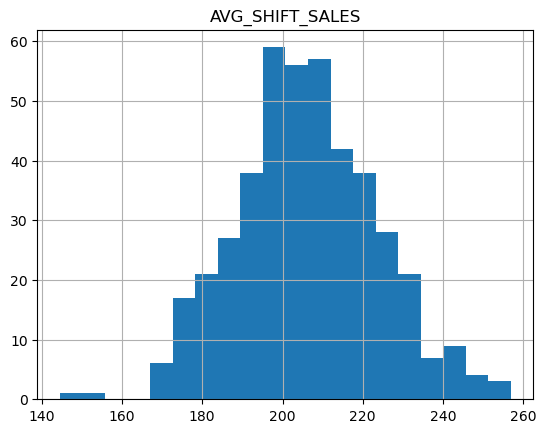

In [19]:
ax = analysis_df.to_pandas().hist(column="AVG_SHIFT_SALES", bins=20, figsize=(3, 1.5))

--------------
# ❄️ FEATURE ENGINEERING ❄️ 
--------------

We will create a feature engineering pipeline by chaining transformations to prepare our data for model training.<br>
**Value:** The Snowpark syntax makes pipelines easy to implement and understand. The syntax also allows for easy migration of Spark pipelines to Snowflake.<br>
**All transformations for feature engineering in this notebook will be executed on Snowflake compute.**

Notice what we haven't had to do? No tuning, maintenance, or operational overhead. We just need a role, warehouse, and access to the data.<br>
**Value**: Near-zero maintenance. Focus on the work that brings value.

## Create a Rolling Average Feature
We will use a Snowflake window function to get a **rolling shift average by location** over time. Window functions allow us to aggregate on a "moving" group of rows.

**Step 1. Create a Window**

Our window will partition the data by location and shift. It will order rows by date. It will include all rows prior to the current date of the observation it is aggregating for.

In [20]:
window_by_location_all_days = (
    Window.partition_by("location_id", "shift")
    .order_by("date")
    .rows_between(Window.UNBOUNDED_PRECEDING, Window.CURRENT_ROW - 1)
)

**Step 2. Aggregate across the Window**

In [21]:
snowpark_df = snowpark_df.with_column(
    "avg_location_shift_sales", 
    F.avg("shift_sales").over(window_by_location_all_days)
)

snowpark_df.show(2)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"CITY"   |"DATE"      |"SHIFT_SALES"  |"SHIFT"  |"MONTH"  |"DAY_OF_WEEK"  |"CITY_POPULATION"  |"LATITUDE"  |"LONGITUDE"  |"LOCATION_NAME"        |"AVG_LOCATION_SHIFT_SALES"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1303           |Toronto  |2015-04-06  |298.91         |PM       |4        |1              |2794356            |43.629078   |-79.581193   |Golf Canada SCOREGolf  |NULL                        |
|1303           |Toronto  |2015-05-30  |550.72         |PM       |5        |6              |2794356            |43.629078   |-79.581193   |Golf Canada SCOREGolf  |298.91                      |
-----------------------------------

--------------
# ❄️ MODEL TRAINING ❄️ 
--------------

## Filter to Historical Data
Our model will provide the predicted sales at each location for the upcoming shift ("AM" or "PM").

Our data includes placeholders for future data with missing **shift_sales**. The **future data** represents the next 7 days of shifts for all locations. The **historical data** has shift sales for all locations where a food truck parked during a shift. We will only use historical data when training our model and will filter out future data (i.e. the dates where the **shift_sales** column is missing).

In [22]:
historical_snowpark_df = snowpark_df.filter(F.col("shift_sales").is_not_null())

## Split data into training and testing

We will initially train our model on all historical data except the most recent year, which we will reserve as a test dataset. The test dataset will be used to evaluate how the model might perform on future data.   

In [23]:
# Obtain the min and max dates present in the historical DataFrame
date_range = historical_snowpark_df.agg(F.min("DATE").alias("MIN_DATE"), F.max("DATE").alias("MAX_DATE")).collect()[0]
min_date = date_range['MIN_DATE']
max_date = date_range['MAX_DATE']

# Obtain the start date for the test set (365 days before the max date)
test_start_date = max_date - timedelta(days=365)

# Create train and test sets (dropping the date column) 
train_snowpark_df = historical_snowpark_df.filter(F.col("DATE") < test_start_date).drop("DATE")
test_snowpark_df = historical_snowpark_df.filter(F.col("DATE") >= test_start_date).drop("DATE")


## Build a Snowpark ML Pipeline

**Snowpark ML** is an integrated set of capabilities for end-to-end machine learning in a single platform on top of your governed data.

In the next cell we will use a Pipeline to build our model. A Pipeline is a tool that sequentially applies a list of transforms and a final estimator, streamlining the process of preprocessing and modeling by combining these steps into a single object. 

This Pipeline first performs **Preprocessing** steps using Snowpark ML pre-processors (SimpleImputer and OneHotEncoder). These steps will replace any missing values in the **avg_location_shift_sales** column with 0. It will also convert the categorical column **SHIFT** into a numeric column with a value of 1 for "AM" shifts and 0 for "PM" shifts. 

Next the Pipeline trains a Snowpark ML **LinearRegression** model using the newly-transformed features and any other features that already existed in the dataset. Features listed in the **passthrough_cols** argument will not be used to train the model. 

Linear regression finds a line that best fits the data points used in training. We then use that line as an estimation of where output values will be for future scenarios. Here, training will use historical shift sales and features in our data to predict future shift sales of locations where our food trucks can park.

In [28]:
# Build the pipeline
pipeline = Pipeline(
    [
        (
            "SimpleImputer (numeric)",
            SimpleImputer(
                input_cols=["AVG_LOCATION_SHIFT_SALES"],
                output_cols=["AVG_LOCATION_SHIFT_SALES"],
                strategy="constant",
                fill_value=0
            ),
        ),
        (
            "OneHotEncoder",
            OneHotEncoder(
                drop=["PM"],
                handle_unknown="ignore",
                input_cols=["SHIFT"],
                output_cols=["SHIFT"],
            ),
        ),
        (
            "LinearRegression",
            LinearRegression(
                label_cols=["SHIFT_SALES"],
                passthrough_cols=['LOCATION_ID', 'CITY', 'DATE', 'SHIFT', 'LOCATION_NAME'],
                output_cols=["FORECASTED_SHIFT_SALES"],
            ),
        ),
    ]
)

# Fit the pipeline on the training data
# We will remove the first column which contains nulls from the rolling average
pipeline.fit(train_snowpark_df.limit(train_snowpark_df.count() - 1, 1))

print("Model has been fit to training dataset.")

Model has been fit to training dataset.


## Examine Feature Contributions
The model object from our fitted Pipeline contains model coefficient estimates, which can be interepreted as feature contributions. Here we temporarily convert the LinearRegression model (the last step of the fitted Pipeline) to an **scikit-learn** verison of the model. This will allow us to access the **coef_** attribute of the model object.

We can see which features have the largest impact on shift sale predictions. The prediction provided by the linear regression model is a summation of the feature values multiplied by their respective coefficients (plus an additional bias term). We can see that there is a large negative coefficient on the SHIFT_AM feature, which suggests that people are hungrier in the afternoon! 

In [32]:
# Can use to_sklearn() method to convert the Snowflake model to a scikit-learn model
model_step = pipeline.steps[-1][1].to_sklearn()

# Create a dataframe of features and their coefficients (weights)
feature_weights = pd.DataFrame({"Feature": model_step.feature_names_in_, "Weight": model_step.coef_})

feature_weights.sort_values("Weight", key=abs, ascending=False)

,Feature,Weight
0,SHIFT_AM,-18.769728
2,MONTH,-6.526725
3,DAY_OF_WEEK,2.733950
1,AVG_LOCATION_SHIFT_SALES,0.980475
5,LATITUDE,-0.321237
6,LONGITUDE,0.106510
4,CITY_POPULATION,0.000008


## Evaluate model performance
To get an idea of how well our model will generalize to future unseen datasets, we will obtain predictions on the test dataset (which was not seen by the model during training) and compare those predictions to the actual values. The performance metrics we calculate can be used when comparing two different models to determine which one will potentially perform better in production. 

First we will predict on the test set. Then we will use Snowpark ML to calculate a handful of standard metrics used to evaluate regression models. For example, **mean absolute error (MAE)** lets us know how far on average our predictions are from the actual values. 

The metrics obtained here will be registered to the Model Registry when we deploy the model later on.

In [33]:
# Obtain predictions on the test set
preds_test = pipeline.predict(test_snowpark_df)

# Show the first few rows of predictions
preds_test.select("LOCATION_ID", "LOCATION_NAME", "SHIFT", "SHIFT_SALES", "FORECASTED_SHIFT_SALES").show(3)

# Calculate Root Mean Square Error (RMSE)
mse = mean_squared_error(df=preds_test, y_true_col_names="SHIFT_SALES", y_pred_col_names="FORECASTED_SHIFT_SALES")
rmse = round(math.sqrt(mse), 4)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(df=preds_test, y_true_col_names="SHIFT_SALES", y_pred_col_names="FORECASTED_SHIFT_SALES")
mae = round(mae, 4)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(df=preds_test, y_true_col_names="SHIFT_SALES", y_pred_col_names="FORECASTED_SHIFT_SALES")
mape = round(mape, 4)

# Create a dictionary containing all the metrics, which will be registered along with the model
test_metrics = {"rmse": rmse, "mae": mae, "mape": mape}
print(test_metrics)

------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"LOCATION_NAME"          |"SHIFT"  |"SHIFT_SALES"  |"FORECASTED_SHIFT_SALES"  |
------------------------------------------------------------------------------------------------
|7906           |Four Points By Sheraton  |PM       |1045.13        |1056.7878763781996        |
|7906           |Four Points By Sheraton  |PM       |760.43         |1068.2330499354484        |
|7906           |Four Points By Sheraton  |PM       |1154.48        |1049.9126419768172        |
------------------------------------------------------------------------------------------------

{'rmse': 375.8557, 'mae': 261.9697, 'mape': 0.3354}


## Fit the pipeline to the entire historical set

Now that we have developed our model and obtained performance metrics on our test set, we can fit the model on the entire historical dataset to ensure that the deployed model will have been trained on the most recent data. We will still use the Pipeline we built above, but we will fit it on a different dataset.

In [34]:
pipeline.fit(historical_snowpark_df.limit(historical_snowpark_df.count() - 1, 1).drop("DATE"))

print("Model has been trained on all historical data")

Model has been trained on all historical data


--------------
# ❄️ MODEL DEPLOYMENT ❄️ 
--------------

## Log the model in the Model Registry
In ML, a model registry is a centralized repository or model store, similar to a library, that lets you effectively manage and organize machine learning models. It is where models are stored, tracked, versioned, and made accessible to anyone at the company involved in deploying and using models in production.

Snowflake provides Model Registry capabilities that will allow you to store your models and model versions in a common location along with metadata related to each model. This greatly streamlines model deployment. Through the Model Registry, Snowflake handles storing the model object and making the model available for inference. 

Model Registries in Snowflake are schema-level objects, so an account can have a single model registry or several model registries for different purposes/business units, depending on the needs of the organization. If a Registry does not already exist in a schema, then one will be created the first time you log a model. 

Here we establish a Registry object, and then use the **log_model** method to place our fitted Pipeline into the Registry along with the evaluation metrics we obtained above. We name the model "**shift_sales_forecaster**", and any time we re-train and log a model with that name, the Registry will store it as a new version. 

In [35]:
reg = Registry(session)
reg.log_model(model=pipeline, model_name="shift_sales_forecaster", metrics=test_metrics)

# Show all models in the registry
reg.show_models()

,created_on,name,database_name,schema_name,comment,owner,default_version_name,versions
0,2024-06-28 12:10:21.893000-07:00,SHIFT_SALES_FORECASTER,FROSTBYTE_TASTY_BYTES_DEV,ANALYTICS,None,TASTY_BYTES_DS_ROLE,STUPID_MOOSE_4,"[""BITTER_BAT_4"",""GENTLE_BOBCAT_2"",""GIANT_LEECH..."


In [29]:
# Show all versions of a specific model ("SHIFT_SALES_FORECASTER" in this case)
reg.get_model("SHIFT_SALES_FORECASTER").show_versions()

,created_on,name,aliases,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-06-28 12:10:21.943000-07:00,STUPID_MOOSE_4,"[""DEFAULT"",""FIRST""]",None,FROSTBYTE_TASTY_BYTES_DEV,ANALYTICS,SHIFT_SALES_FORECASTER,true,"[""PREDICT""]","{""metrics"": {""rmse"": 375.8557, ""mae"": 261.9697...",{}
1,2024-06-28 12:12:41.551000-07:00,UGLY_ROBIN_3,[],None,FROSTBYTE_TASTY_BYTES_DEV,ANALYTICS,SHIFT_SALES_FORECASTER,false,"[""PREDICT""]","{""metrics"": {""rmse"": 375.8557, ""mae"": 261.9697...",{}
2,2024-07-02 05:55:37.542000-07:00,BITTER_BAT_4,[],None,FROSTBYTE_TASTY_BYTES_DEV,ANALYTICS,SHIFT_SALES_FORECASTER,false,"[""PREDICT""]","{""metrics"": {""rmse"": 375.8557, ""mae"": 261.9697...",{}
3,2024-07-02 06:29:20.995000-07:00,GENTLE_BOBCAT_2,[],None,FROSTBYTE_TASTY_BYTES_DEV,ANALYTICS,SHIFT_SALES_FORECASTER,false,"[""PREDICT""]","{""metrics"": {""rmse"": 375.8557, ""mae"": 261.9697...",{}
4,2024-07-02 06:45:31.906000-07:00,MODERN_FIREFOX_3,[],None,FROSTBYTE_TASTY_BYTES_DEV,ANALYTICS,SHIFT_SALES_FORECASTER,false,"[""PREDICT""]","{""metrics"": {""rmse"": 375.8557, ""mae"": 261.9697...",{}
5,2024-07-02 07:55:01.386000-07:00,LOUD_FALCON_4,"[""LAST""]",None,FROSTBYTE_TASTY_BYTES_DEV,ANALYTICS,SHIFT_SALES_FORECASTER,false,"[""PREDICT""]","{""metrics"": {""rmse"": 375.8557, ""mae"": 261.9697...",{}


--------------
# ❄️ INFERENCE ❄️ 
--------------

## Predict for tomorrow morning's shift in Vancouver

Now that our model is deployed, we can use it in Snowflake on our data to get shift sales predictions. 

First we will filter to the morning shift of the first future date in our data and Vancouver locations. 

In [37]:
# Get the date to predict
date_tomorrow = snowpark_df.filter(F.col("shift_sales").is_null()).select(F.min("date")).collect()[0][0]
# Filter to tomorrow's date and the morning shift in Vancouver
location_predictions_df = snowpark_df.filter((F.col("date") == date_tomorrow) 
                                             & (F.col("shift") == "AM") 
                                             & (F.col("city")=="Vancouver")).drop("DATE")

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"CITY"     |"SHIFT_SALES"  |"SHIFT"  |"LOCATION_NAME"         |"SHIFT_AM"  |"AVG_LOCATION_SHIFT_SALES"  |"MONTH"  |"DAY_OF_WEEK"  |"CITY_POPULATION"  |"LATITUDE"  |"LONGITUDE"  |"FORECASTED_SHIFT_SALES"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2424           |Vancouver  |NULL           |AM       |Flowers by Michael      |1           |164.18241758241757          |5        |1              |662248             |49.288758   |-123.128241  |217.78042678838736        |
|5192           |Vancouver  |NULL           |AM       |Dreamgroup Productions  |1           |167.91547619047

Next we will access the model in the Model Registry. We use the **.default** attribute to specify that we would like to use the "default" version of the model. You can set any version to be the "default" version. Often the "default" version is chosen to be the most recent version of the model or the one with the best performance metric.  

To obtain our predictions we simply set function_name="predict" in the **run** method.

In [38]:
# Obtain predictions
inference_df = reg.get_model("SHIFT_SALES_FORECASTER").default.run(X=location_predictions_df, function_name="predict")
inference_df.show(3)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"CITY"     |"SHIFT_SALES"  |"SHIFT"  |"LOCATION_NAME"         |"SHIFT_AM"  |"AVG_LOCATION_SHIFT_SALES"  |"MONTH"  |"DAY_OF_WEEK"  |"CITY_POPULATION"  |"LATITUDE"  |"LONGITUDE"  |"FORECASTED_SHIFT_SALES"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2636           |Vancouver  |NULL           |AM       |Central Parking System  |1           |173.6669911504424           |5        |1              |662248             |49.289678   |-123.128364  |228.20432191891774        |
|2127           |Vancouver  |NULL           |AM       |Formally Kirkpatrick    |1           |131.90425000000